In [101]:
# 기초 전처리
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import os

import warnings
warnings.filterwarnings(action = 'ignore')

# pandas 결과값의 표현 범위 소수점 2자리수로 변경
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)

In [2]:
# FastText에서 유사도로 측정한 맛, 친절, 분위기, 가격(긍정/부정) 에 대한 유의어 사전 load
import json

f = open('./data/base_data/keyword_dict.json')

keyword_dict = json.load(f)

f.close()

##### 필요 함수 정의

In [120]:
def load_data(path):
    df = pd.read_csv(path, encoding='CP949')
    df = df[ df['상권_구분_코드']=='A' ]  # 골목상권으로 테이블 제한
    
    return df

# 전체 과정 설명
1. 웹크롤링한 서울시 상점정보를 geojson으로 만든다. (상점별 x,y좌표 보유한 df)
2. Qgis를 활용 상점별 좌표를 기준으로 최근접 이웃 알고리즘으로 가장 인근에 위치한 상권과 연결 시킨다.
3. Qgis로 작업한 geojson파일을 불러와서 상점정보 & 상권정보와 연결 시킨다. => 각 상점별 정보 + 상권정보 테이블 생성 (10281개 매장)
4. 웹크롤링한 매장별 리뷰데이터를 3)에서 만든 테이블과 연결하여 각 매장별 리뷰 테이블을 만든다.

# 서울시 상점 정보로 geojson만들기

In [3]:
# 서울시 상점 정보 불러오기
df = pd.read_csv('./data/row_data/가게정보_서울시.csv')
df.head(5)

,name,code_ne,r_type,address,tel,score,detail,strong,datalab_1,review_num,blog_num,x,y
0,이삭토스트 개포동역점,38473617,토스트,서울 강남구 개포로 512 1층 109호,02-451-5421,4.7,이삭토스트 서울 개포동역점의 바로주문 페이지 입니다. [찾아오시는 길] -개포동역(...,NaN,{},239,15.0,127.07,37.49
1,개포동장군주먹고기,1258223030,돼지고기구이,서울 강남구 개포로82길 9-15 1층,0507-1300-7367,4.49,개포동 186-9 1층입니다. 개포 5단지 인근 상가거리에있습니다. 개포동역 5번출...,NaN,{},49,20.0,127.07,37.49
2,드림트레이,1760835531,"카페,디저트",서울 강남구 논현로18길 16 지상1층,010-3845-6911,4.78,매장 앞에 주차공간 2~3대 가능합니다.,NaN,{},49,62.0,127.05,37.48
3,라피노,1780901162,이탈리아음식,서울 강남구 개포로24길 29 하임빌딩 1층,02-575-1220,4.78,3호선 양재역 5번 출구(남부농협) 강남02번 마을버스 광수빌딩 또는 달터공원 정류...,NaN,{},307,251.0,127.05,37.48
4,블랑커피,1744014091,"카페,디저트",서울 강남구 개포로22길 54 1층 블랑커피,02-575-5637,4.56,매봉역 도보 15분거리 국악고등학교 정문 도보 2분거리,NaN,{},63,23.0,127.05,37.48


In [4]:
# 필요 컬럼만 추출
store  = df[['name','x','y']]

In [5]:
# geojson변환 위해 좌표지정
from shapely.geometry import Point
pd.reset_option('display.float_format')
store['x'] = store.x.astype(float)
store['y'] = store.y.astype(float)

# geojson으로 변환
geometry = [Point(xy) for xy in zip(store.x, store.y)]
store_w_gpd = gpd.GeoDataFrame(store, crs='EPSG:4326', geometry=geometry)

In [6]:
store_w_gpd.head()

,name,x,y,geometry
0,이삭토스트 개포동역점,127.068842,37.489307,POINT (127.06884 37.48931)
1,개포동장군주먹고기,127.068254,37.488977,POINT (127.06825 37.48898)
2,드림트레이,127.046346,37.477771,POINT (127.04635 37.47777)
3,라피노,127.049622,37.477314,POINT (127.04962 37.47731)
4,블랑커피,127.050083,37.475814,POINT (127.05008 37.47581)


In [7]:
# 결과 저장
store_w_gpd.to_file("./data/geo/서울시_상점좌표.geojson", driver='GeoJSON', encoding='utf-8')

# Qgis로 일치영역 찾기
- 상권_geometry_좌표(골목).geojson 에서 각 상점의 중심점을 구하고 서울시 상점좌표(store_w_gpd)를 활용해 둘 사이의 최근접 허브(포인트)를 계산 (결과값 HubName에 저장)
- 각 상점 별로 가장 근접한 상권(HubName)을 찾았다.

# 상권정보와 상점정보 합치기

In [8]:
# 상권 관련 정보 
place = gpd.read_file('./data/geo/상점_인근_상권.geojson', driver= 'GeoJSON', encoding='cp949')

# 상권 내 상점 정보
bs_area = gpd.read_file('./data/geo/상권_geometry_좌표(골목).geojson', driver= 'GeoJSON', encoding='cp949')

In [9]:
# 상권내 존재하는 상점 정보(place) & 상권에 대한 정보(bs_area)를 '상권명' 기준으로 병합
merged_df = pd.merge(place, bs_area, left_on='HubName',right_on='TRDAR_CD_N')
merged_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10569 entries, 0 to 10568
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   name        10569 non-null  object  
 1   HubName     10569 non-null  object  
 2   geometry_x  10569 non-null  geometry
 3   TRDAR_SE_C  10569 non-null  object  
 4   TRDAR_SE_1  10569 non-null  object  
 5   TRDAR_CD    10569 non-null  object  
 6   TRDAR_CD_N  10569 non-null  object  
 7   XCNTS_VALU  10569 non-null  int64   
 8   YDNTS_VALU  10569 non-null  int64   
 9   SIGNGU_CD   10569 non-null  object  
 10  ADSTRD_CD   10569 non-null  object  
 11  STDR_YM_CD  10569 non-null  object  
 12  area        10569 non-null  float64 
 13  perimeter   10569 non-null  float64 
 14  x           10569 non-null  float64 
 15  y           10569 non-null  float64 
 16  geometry_y  10569 non-null  geometry
dtypes: float64(4), geometry(2), int64(2), object(9)
memory usage: 1.5+ MB


In [10]:
# 필요 컬럼 추출 (병합 예정)
merged_bs_area  = merged_df[['name','TRDAR_CD','TRDAR_CD_N']]
merged_bs_area.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10569 entries, 0 to 10568
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        10569 non-null  object
 1   TRDAR_CD    10569 non-null  object
 2   TRDAR_CD_N  10569 non-null  object
dtypes: object(3)
memory usage: 330.3+ KB


In [11]:
# 상점 정보에서 필요 내용만 추출
store2  = df[['name','code_ne','r_type','address','score','review_num','blog_num','x','y']]
store2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10569 entries, 0 to 10568
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        10569 non-null  object 
 1   code_ne     10569 non-null  int64  
 2   r_type      10569 non-null  object 
 3   address     10569 non-null  object 
 4   score       10551 non-null  object 
 5   review_num  10486 non-null  object 
 6   blog_num    10225 non-null  object 
 7   x           10569 non-null  float64
 8   y           10569 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 743.3+ KB


In [12]:
# 상점 정보 & 상권 내 상점 정보 & 상권 정보 병합
store_review_by_bs = pd.merge(merged_bs_area, store2, on='name', how='left')
store_review_by_bs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11203 entries, 0 to 11202
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        11203 non-null  object 
 1   TRDAR_CD    11203 non-null  object 
 2   TRDAR_CD_N  11203 non-null  object 
 3   code_ne     11203 non-null  int64  
 4   r_type      11203 non-null  object 
 5   address     11203 non-null  object 
 6   score       11185 non-null  object 
 7   review_num  11118 non-null  object 
 8   blog_num    10847 non-null  object 
 9   x           11203 non-null  float64
 10  y           11203 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.0+ MB


In [13]:
# 상점 수의 unique값이 일치하는 것으로 보아 유실된 데이터가 없다.
print(f'기존 상점의 개수:', len(store['name'].unique()))
print(f'상권내 상점의 개수:', len(store_review_by_bs['name'].unique()))

print(f'상권개수:', len(store_review_by_bs['TRDAR_CD'].unique()))

기존 상점의 개수: 10281
상권내 상점의 개수: 10281
상권개수: 879


In [14]:
# 중복값 발생 이를 제거
store_review_by_bs = store_review_by_bs.drop_duplicates('name')

In [15]:
# x,y는 상점의 좌표
store_review_by_bs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10281 entries, 0 to 11202
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        10281 non-null  object 
 1   TRDAR_CD    10281 non-null  object 
 2   TRDAR_CD_N  10281 non-null  object 
 3   code_ne     10281 non-null  int64  
 4   r_type      10281 non-null  object 
 5   address     10281 non-null  object 
 6   score       10263 non-null  object 
 7   review_num  10199 non-null  object 
 8   blog_num    9943 non-null   object 
 9   x           10281 non-null  float64
 10  y           10281 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 963.8+ KB


In [16]:
store_review_by_bs.head()

,name,TRDAR_CD,TRDAR_CD_N,code_ne,r_type,address,score,review_num,blog_num,x,y
0,이삭토스트 개포동역점,1000892,개포로82길,38473617,토스트,서울 강남구 개포로 512 1층 109호,4.7,239,15.0,127.068842,37.489307
1,개포동장군주먹고기,1000892,개포로82길,1258223030,돼지고기구이,서울 강남구 개포로82길 9-15 1층,4.49,49,20.0,127.068254,37.488977
2,커피마마퀸 개포동점,1000892,개포로82길,1233704717,"카페,디저트",서울 강남구 삼성로 38,4.75,51,7.0,127.066845,37.488688
3,강남초장,1000892,개포로82길,1277913587,생선회,서울 강남구 개포로 510 1층 110~111호,4.04,23,10.0,127.068344,37.489288
4,스텔라떡볶이 개포점,1000892,개포로82길,1264091478,떡볶이,"서울 강남구 개포로82길 13-15 지상1층 5호, 9호",4.51,67,48.0,127.068348,37.488821


In [17]:
# 결과 저장
store_review_by_bs.to_csv('./data/row_data/상권_내_상점.csv', encoding='utf-8')

In [18]:
store_review_by_bs.head()

,name,TRDAR_CD,TRDAR_CD_N,code_ne,r_type,address,score,review_num,blog_num,x,y
0,이삭토스트 개포동역점,1000892,개포로82길,38473617,토스트,서울 강남구 개포로 512 1층 109호,4.7,239,15.0,127.068842,37.489307
1,개포동장군주먹고기,1000892,개포로82길,1258223030,돼지고기구이,서울 강남구 개포로82길 9-15 1층,4.49,49,20.0,127.068254,37.488977
2,커피마마퀸 개포동점,1000892,개포로82길,1233704717,"카페,디저트",서울 강남구 삼성로 38,4.75,51,7.0,127.066845,37.488688
3,강남초장,1000892,개포로82길,1277913587,생선회,서울 강남구 개포로 510 1층 110~111호,4.04,23,10.0,127.068344,37.489288
4,스텔라떡볶이 개포점,1000892,개포로82길,1264091478,떡볶이,"서울 강남구 개포로82길 13-15 지상1층 5호, 9호",4.51,67,48.0,127.068348,37.488821


# 상권별 리뷰데이터 생성

In [19]:
review_data = pd.read_csv('./data/row_data/리뷰정보_서울시.csv', encoding='utf-8')
review_data.info() # 총 1105677개의 리뷰

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136877 entries, 0 to 1136876
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   name           1136877 non-null  object 
 1   code_no        1136877 non-null  int64  
 2   reviewer_info  1136877 non-null  object 
 3   r_score        1136877 non-null  float64
 4   r_date         1136877 non-null  object 
 5   r_times        1136877 non-null  object 
 6   proving        1136690 non-null  object 
 7   r_comments     1105677 non-null  object 
 8   owner_reply    90998 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 78.1+ MB


In [20]:
review_data.head()

,name,code_no,reviewer_info,r_score,r_date,r_times,proving,r_comments,owner_reply
0,이삭토스트 개포동역점,38473617,"{'평균_별점': '5', '사진': 'NA', '리뷰': '1'}",5.0,2021.10.04,2번째 방문,주문,맛있어요! ㅋㅋ사장님 두분도 친절하세요! 최고,NaN
1,이삭토스트 개포동역점,38473617,"{'평균_별점': '4.5', '사진': 6, '리뷰': '4'}",5.0,2021.10.02,3번째 방문,주문,맛있고 친절해요!!,감사합니다 ^^**********
2,이삭토스트 개포동역점,38473617,"{'평균_별점': '4', '사진': 'NA', '리뷰': '369'}",4.0,2021.09.27,1번째 방문,영수증,굿,감사합니다 ^^
3,이삭토스트 개포동역점,38473617,"{'평균_별점': '4.1', '사진': 'NA', '리뷰': '490'}",3.5,2021.09.27,1번째 방문,영수증,굿,감사합니다 ^^
4,이삭토스트 개포동역점,38473617,"{'평균_별점': '4.6', '사진': 'NA', '리뷰': '64'}",5.0,2021.09.23,1번째 방문,영수증,사장님 친절하세용ㅎㅎ,감사합니다 ^^


In [21]:
# store_review_by_bs(상권별 상점 데이터) 와 리뷰데이터 병합
review_by_bs_area = pd.merge(store_review_by_bs, review_data, on='name', how='left')
review_by_bs_area.head(5)

,name,TRDAR_CD,TRDAR_CD_N,code_ne,r_type,address,score,review_num,blog_num,x,y,code_no,reviewer_info,r_score,r_date,r_times,proving,r_comments,owner_reply
0,이삭토스트 개포동역점,1000892,개포로82길,38473617,토스트,서울 강남구 개포로 512 1층 109호,4.7,239,15.0,127.068842,37.489307,38473617.0,"{'평균_별점': '5', '사진': 'NA', '리뷰': '1'}",5.0,2021.10.04,2번째 방문,주문,맛있어요! ㅋㅋ사장님 두분도 친절하세요! 최고,NaN
1,이삭토스트 개포동역점,1000892,개포로82길,38473617,토스트,서울 강남구 개포로 512 1층 109호,4.7,239,15.0,127.068842,37.489307,38473617.0,"{'평균_별점': '4.5', '사진': 6, '리뷰': '4'}",5.0,2021.10.02,3번째 방문,주문,맛있고 친절해요!!,감사합니다 ^^**********
2,이삭토스트 개포동역점,1000892,개포로82길,38473617,토스트,서울 강남구 개포로 512 1층 109호,4.7,239,15.0,127.068842,37.489307,38473617.0,"{'평균_별점': '4', '사진': 'NA', '리뷰': '369'}",4.0,2021.09.27,1번째 방문,영수증,굿,감사합니다 ^^
3,이삭토스트 개포동역점,1000892,개포로82길,38473617,토스트,서울 강남구 개포로 512 1층 109호,4.7,239,15.0,127.068842,37.489307,38473617.0,"{'평균_별점': '4.1', '사진': 'NA', '리뷰': '490'}",3.5,2021.09.27,1번째 방문,영수증,굿,감사합니다 ^^
4,이삭토스트 개포동역점,1000892,개포로82길,38473617,토스트,서울 강남구 개포로 512 1층 109호,4.7,239,15.0,127.068842,37.489307,38473617.0,"{'평균_별점': '4.6', '사진': 'NA', '리뷰': '64'}",5.0,2021.09.23,1번째 방문,영수증,사장님 친절하세용ㅎㅎ,감사합니다 ^^


# 상권별 비율 지표 뽑아내기

## 상권별 review 비율

In [22]:
# review 없는 row 삭제
review_by_bs_area = review_by_bs_area[review_by_bs_area['r_comments'].notna()]

In [23]:
review_by_bs_area.isnull().sum()

name                   0
TRDAR_CD               0
TRDAR_CD_N             0
code_ne                0
r_type                 0
address                0
score                  0
review_num            85
blog_num            5334
x                      0
y                      0
code_no                0
reviewer_info          0
r_score                0
r_date                 0
r_times                0
proving              187
r_comments             0
owner_reply      1016091
dtype: int64

In [24]:
# 상권별 review 수
review_cnt_by_bs_area = review_by_bs_area.groupby(['TRDAR_CD'])['r_comments'].count()
df = review_cnt_by_bs_area.to_frame()

In [25]:
df.reset_index(inplace=True)
df.rename(columns = {'r_comments' : 'review_cnt'}, inplace = True)
df.head()

,TRDAR_CD,review_cnt
0,1000001,1392
1,1000002,424
2,1000003,6280
3,1000004,1951
4,1000005,5527


In [26]:
# 상권별 review 비율
total_review_cnt = df['review_cnt'].sum()
df['review_ratio'] = df['review_cnt']/total_review_cnt
df.head()

,TRDAR_CD,review_cnt,review_ratio
0,1000001,1392,0.001259
1,1000002,424,0.000383
2,1000003,6280,0.005680
3,1000004,1951,0.001765
4,1000005,5527,0.004999


## 상권별 평균 평점

In [27]:
review_by_bs_area['score'].replace('1,099',1099,inplace=True)
review_by_bs_area['score'] = review_by_bs_area['r_score'].astype('float')

In [28]:
# 상권별 평균평점
avg_score = review_by_bs_area.groupby(['TRDAR_CD'])['r_score'].mean()
df_score = avg_score.to_frame()

In [29]:
df_score.reset_index(inplace=True)
df_score.rename(columns = {'r_score' : 'avg_score'}, inplace = True)
df_score

,TRDAR_CD,avg_score
0,1000001,4.414511
1,1000002,4.198113
2,1000003,4.366481
3,1000004,4.237314
4,1000005,4.425547
...,...,...
870,1001006,4.344002
871,1001007,4.368866
872,1001008,4.479642
873,1001009,4.633962


In [30]:
df = pd.merge(df, df_score, on='TRDAR_CD')
df.head(1)

,TRDAR_CD,review_cnt,review_ratio,avg_score
0,1000001,1392,0.001259,4.414511


# owner 응답률

In [31]:
review_by_bs_area['owner_reply'].fillna('활활활활', inplace=True)

def change_1(x):
    if x == '활활활활':
        return 0
    else:
        return 1

review_by_bs_area['tmp'] = review_by_bs_area['owner_reply'].apply(change_1)
상권당_평균리플 = review_by_bs_area.groupby(['TRDAR_CD'])['tmp'].mean().to_frame()

In [32]:
df = pd.merge(df, 상권당_평균리플, left_on='TRDAR_CD', right_index=True)
df.head(1)

,TRDAR_CD,review_cnt,review_ratio,avg_score,tmp
0,1000001,1392,0.001259,4.414511,0.081178


##### 각 상권당 맛에 대해서 표현한 리뷰(맛있다)의 비율

In [33]:
def change_2(x, key):
    for val in keyword_dict[key]:
        if val in x:
            return 1
    else:
        return 0

In [34]:
from tqdm import tqdm_notebook

sorts = ['taste','kindness','mood', 'pos_price', 'neg_price']
for i in tqdm_notebook(sorts):
    review_by_bs_area['tmp_'+i] = review_by_bs_area['r_comments'].apply(lambda x: change_2(x,i))

  0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
df2 = df.copy()
for i in review_by_bs_area.columns[-5:]:
    상권당_평균리플 = (review_by_bs_area.groupby(['TRDAR_CD'])[i].mean()/review_by_bs_area[i].mean()).to_frame()
    df2 = pd.merge(df2, 상권당_평균리플, left_on='TRDAR_CD', right_index=True)
df2.head()

,TRDAR_CD,review_cnt,review_ratio,avg_score,tmp,tmp_taste,tmp_kindness,tmp_mood,tmp_pos_price,tmp_neg_price
0,1000001,1392,0.001259,4.414511,0.081178,0.961996,1.003691,1.361636,0.632719,1.025315
1,1000002,424,0.000383,4.198113,0.002358,0.920931,0.823784,0.605000,0.307737,0.655576
2,1000003,6280,0.005680,4.366481,0.062102,1.020808,1.173287,1.460663,0.851864,1.173789
3,1000004,1951,0.001765,4.237314,0.015889,0.976569,0.635125,0.840019,0.894505,0.928812
4,1000005,5527,0.004999,4.425547,0.065497,1.001339,1.029193,1.483470,0.882344,1.080312


In [57]:
df2.columns=['상권_코드', '리뷰_수', '리뷰_비율', '평균_별점', '사장님_댓글_비율',
             '맛있다_비율','친절_비율', '분위기_비율','싸다_비율','비싸다_비율']
df2['상권_코드'] = df2['상권_코드'].astype(int)
df2.head(1)

,상권_코드,리뷰_수,리뷰_비율,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율
0,1000001,1392,0.001259,4.414511,0.081178,0.961996,1.003691,1.361636,0.632719,1.025315


In [58]:
base_df = pd.read_csv('./data/base_data/df_base.csv')
df2 = pd.merge(base_df, df2, on='상권_코드', how='left')
df2.head()

,상권_코드,리뷰_수,리뷰_비율,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율
0,1000001,1392.0,0.001259,4.414511,0.081178,0.961996,1.003691,1.361636,0.632719,1.025315
1,1000002,424.0,0.000383,4.198113,0.002358,0.920931,0.823784,0.605000,0.307737,0.655576
2,1000003,6280.0,0.005680,4.366481,0.062102,1.020808,1.173287,1.460663,0.851864,1.173789
3,1000004,1951.0,0.001765,4.237314,0.015889,0.976569,0.635125,0.840019,0.894505,0.928812
4,1000005,5527.0,0.004999,4.425547,0.065497,1.001339,1.029193,1.483470,0.882344,1.080312


In [59]:
df2.shape

(1009, 10)

# 유클리드 거리 기반으로 다시 상권코드 묶기

In [74]:
bs_near= pd.read_csv('data/base_data/near_CD.csv')
bs_near.columns = ['상권_코드']+bs_near.columns[1:].to_list()
bs_near = bs_near[bs_near['상권_코드'] != 1000805]
print(bs_near.shape)
bs_near.head()

(1009, 5)


,상권_코드,near_CD,near_CD2,near_CD3,near_CD4
0,1000334,1000343,1000344,1000315,1000327
1,1000354,1000376,1000346,1000360,1000348
2,1000355,1000372,1000356,1000357,1000361
3,1000356,1000355,1000369,1000372,1000357
4,1000357,1000358,1000355,1000362,1000374


In [84]:
while df2.isnull().sum().sum():
    for i, values in df2.iterrows():
        for j, col in enumerate(df2.columns):
            if pd.isnull(values[col]):
                for near_col in ['near_CD','near_CD2','near_CD3', 'near_CD4']:
                    near_CD = bs_near[bs_near['상권_코드']==values['상권_코드']][near_col].values[0]
                    temp = df2[df2['상권_코드']==near_CD][col].values
                    if pd.isnull(temp):
                        pass
                    else:
                        break

                df2.iloc[i,j] = temp

# 

In [116]:
food_sns = pd.read_csv('./data/row_data/Seoul_Food_Go_out_Index.csv')

mapping = {'강남구': 11680, '강동구': 11740, '강북구': 11305, '강서구': 11500, 
           '관악구': 11620, '광진구': 11215, '구로구': 11530, '금천구': 11545, 
           '노원구': 11350, '도봉구': 11320, '동대문구': 11230, '동작구': 11590, 
           '마포구': 11440, '서대문구': 11410, '서초구': 11650, '성동구': 11200,
           '성북구': 11290, '송파구': 11710, '양천구': 11470, '영등포구': 11560, 
           '용산구': 11170, '은평구': 11380, '종로구': 11110, '중구': 11140, '중랑구': 11260}
food_sns['REGION'] = food_sns['REGION'].map(mapping) 

for col in food_sns.columns:
    if 'MA' in col or 'MIN' in col or 'AVG' in col:
        food_sns.drop(col, axis=1, inplace=True)

food_sns = food_sns.iloc[:,2:]
food_sns.head()

,REGION,USE_FREQ,BUZZ_FREQ,TRACTION_A,TRACTION_B,TRACTION_C,ATTRACTION_A,ATTRACTION_B,ATTRACTION_C,INDEX,UNIT_PRICE
0,11680,2.89,6.84,5.58,5.18,4.92,-1.26,-1.66,-1.92,2.71,30766
1,11680,3.13,6.25,5.17,4.63,4.56,-1.08,-1.62,-1.69,2.64,25929
2,11680,3.11,6.56,5.52,5.72,5.10,-1.04,-0.84,-1.46,2.85,29216
3,11680,2.84,7.19,7.11,5.78,5.37,-0.08,-1.41,-1.82,2.98,25614
4,11680,2.67,6.65,5.88,4.49,4.04,-0.77,-2.16,-2.61,2.49,30672


In [123]:
reg_code = load_data('./data/row_data/서울시 우리마을가게 상권분석서비스(상권영역).csv')
reg_code = reg_code[['상권_코드','시군구_코드']]
reg_code = reg_code[reg_code['상권_코드'] != 1000805]
sns_df = pd.merge(food_sns, reg_code, left_on='REGION', right_on='시군구_코드', how='right')

sns_df = sns_df.groupby('상권_코드').mean()
sns_df = sns_df.iloc[:,1:-1]
sns_df

,USE_FREQ,BUZZ_FREQ,TRACTION_A,TRACTION_B,TRACTION_C,ATTRACTION_A,ATTRACTION_B,ATTRACTION_C,INDEX,UNIT_PRICE
상권_코드,,,,,,,,,,
1000001,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
1000002,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
1000003,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
1000004,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
1000005,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
...,...,...,...,...,...,...,...,...,...,...
1001006,0.34,0.35,0.34,0.28,0.29,-0.02,-0.07,-0.06,0.21,26598.05
1001007,0.34,0.35,0.34,0.28,0.29,-0.02,-0.07,-0.06,0.21,26598.05
1001008,0.34,0.35,0.34,0.28,0.29,-0.02,-0.07,-0.06,0.21,26598.05


<AxesSubplot:>

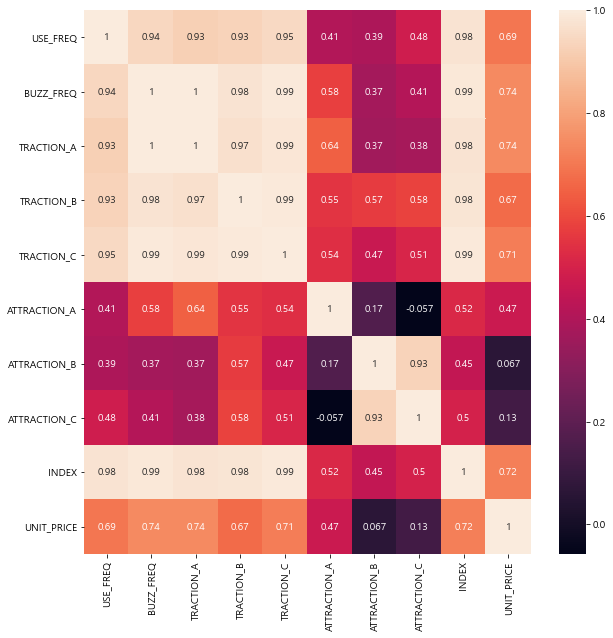

In [127]:
import seaborn
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
seaborn.heatmap(sns_df.corr(), annot=True)

In [128]:
df_full = pd.merge(df2, sns_df, left_on='상권_코드', right_index=True)

path = './data/indicator/preprocess_cul.csv'
df_full.to_csv(path, index=False)
pd.read_csv(path).head()

,상권_코드,리뷰_수,리뷰_비율,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율,USE_FREQ,BUZZ_FREQ,TRACTION_A,TRACTION_B,TRACTION_C,ATTRACTION_A,ATTRACTION_B,ATTRACTION_C,INDEX,UNIT_PRICE
0,1000001,1392.00,0.00,4.41,0.08,0.96,1.00,1.36,0.63,1.03,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
1,1000002,424.00,0.00,4.20,0.00,0.92,0.82,0.60,0.31,0.66,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
2,1000003,6280.00,0.01,4.37,0.06,1.02,1.17,1.46,0.85,1.17,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
3,1000004,1951.00,0.00,4.24,0.02,0.98,0.64,0.84,0.89,0.93,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39
4,1000005,5527.00,0.00,4.43,0.07,1.00,1.03,1.48,0.88,1.08,2.75,3.24,2.93,2.95,3.33,-0.32,-0.30,0.08,1.94,28156.39


In [129]:
path = './data/indicator/preprocess_cul.csv'
df2.to_csv(path, index=False)
pd.read_csv(path).head()

,상권_코드,리뷰_수,리뷰_비율,평균_별점,사장님_댓글_비율,맛있다_비율,친절_비율,분위기_비율,싸다_비율,비싸다_비율
0,1000001,1392.00,0.00,4.41,0.08,0.96,1.00,1.36,0.63,1.03
1,1000002,424.00,0.00,4.20,0.00,0.92,0.82,0.60,0.31,0.66
2,1000003,6280.00,0.01,4.37,0.06,1.02,1.17,1.46,0.85,1.17
3,1000004,1951.00,0.00,4.24,0.02,0.98,0.64,0.84,0.89,0.93
4,1000005,5527.00,0.00,4.43,0.07,1.00,1.03,1.48,0.88,1.08
